In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
import numba

In [3]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

config = Config(dt = 0.01, trajs = int(2), dims = [1], mass_real = 1, interaction = 2, ada_step = True)
sim = ComplexLangevinSimulation(config)
sim.register_observable('2_moment', obs_kernel=n_moment_kernel, const_param={'order': 2}, langevin_history=False, thermal_time=0, auto_corr=0.1)

Using double precision
Using C^1
Using Numba


In [4]:
def calculate_stats_complex(rolling_mean, rolling_sqr_mean, counter):
    """
    Calculate mean and SEM for complex numbers.
    
    Parameters:
    rolling_mean (np.array): Single-element array containing the rolling sum of complex values.
    rolling_sqr_mean (np.array): Single-element array containing the rolling sum of squared magnitudes of complex values.
    counter (np.array): Single-element array containing the number of values.
    
    Returns:
    tuple: (mean, sem_real, sem_imag), where:
        - mean is the complex mean,
        - sem_real is the SEM for the real part,
        - sem_imag is the SEM for the imaginary part.
    """
    if counter[0] == 0:
        raise ValueError("Counter cannot be zero to avoid division by zero.")
    
    # Extract real and imaginary parts
    rolling_mean_real = rolling_mean[0].real
    rolling_mean_imag = rolling_mean[0].imag
    
    # Mean calculation
    mean_real = rolling_mean_real / counter[0]
    mean_imag = rolling_mean_imag / counter[0]
    
    # Variance for real part
    rolling_sqr_mean_real = rolling_sqr_mean[0]
    variance = (rolling_sqr_mean_real / counter[0]) - mean_real**2 - mean_imag**2
    variance = max(variance, 0)
        
    # Standard error of the mean (SEM)
    sem = np.sqrt(variance / counter[0])
    
    # Return complex mean and SEM for real and imaginary parts
    mean = mean_real + 1j * mean_imag
    return mean, sem


In [9]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm


errors_dict = {'4_moment': [], '2_moment': [], '1_moment': []}
cl_estimate_dict = {'4_moment': [], '2_moment': [], '1_moment': []}
cl_hist_dict =  {'4_moment': [], '2_moment': [], '1_moment': []}
angles_dict = {'4_moment': [], '2_moment': [], '1_moment': []}
num = 32
angles = np.arange(num)/num*np.pi*2

sigma_abs = 4
sigma_vals_cl = sigma_abs*(np.cos(angles) + 1j*np.sin(angles))


for angle, sigma in zip(angles, (sigma_vals_cl)):
    config = Config(dt = 5e-4, trajs = int(1e6), dims = [1], mass_real = sigma, interaction = 2, ada_step = True)
    sim = ComplexLangevinSimulation(config)
    
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True, thermal_time=2, auto_corr=0.1)
    sim.register_observable('2_moment', obs_kernel=n_moment_kernel, const_param={'order': 2}, langevin_history=False, thermal_time=2, auto_corr=0.1)
    sim.register_observable('4_moment', obs_kernel=n_moment_kernel, const_param={'order': 4}, langevin_history=False, thermal_time=2, auto_corr=0.1)

    for _ in tqdm(range(int(1e4))):
        sim.step()
        for name, tr in sim.trackers.items():
            tr.mark_equilibrated_trajs()
            tr.compute()
    sim.finish()

    for name, tr in sim.trackers.items():
        mean, sem = calculate_stats_complex(tr.rolling_mean, tr.rolling_sqr_mean, tr.counter)
        cl_estimate_dict[name].append(mean)
        errors_dict[name].append(sem)
        angles_dict[name].append(angle)
        cl_hist_dict[name].append(sim.trackers['1_moment'].history.flatten())

 16%|█▌        | 1599/10000 [00:14<01:14, 112.92it/s]


KeyboardInterrupt: 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
# axes = axes.flatten()
# fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

# for idx, da in enumerate(cl_hist_dict['4_moment']):
    
#     magnitudes = np.abs(da)
#     da = da[magnitudes <= 20]   
#     art_dp = 10+10j
#     da = np.append([art_dp, -art_dp], da)
#     real_parts, imag_parts = da.real, da.imag
#     bins = 500
#     heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

#     ax = axes[idx]
#     # Plot the heatmap
#     ax.imshow(
#         np.log10(heatmap+1).T,
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#         origin='lower',
#         cmap='hot',
#         aspect='auto',
#     )
#     label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"

#     ax.set_title(label)
#     ax.set_xlim(-6, 6)
#     ax.set_ylim(-6, 6)
# plt.show()

In [ ]:
# exact_angles = np.linspace(0, 2*np.pi, 100)
from analytic.analysis import Analysis
exact = Analysis()

from sympy import symbols, exp, sqrt, diff
from sympy.functions.special.bessel import besselk

sigma, lamda = symbols('sigma lamda')

xi = sigma**2 / (8 * lamda)
K_neg1_4 = besselk(-1/4, xi)
f_sigma = sqrt(4 * xi / sigma) * exp(xi) * K_neg1_4
exact.set_func('Z', f_sigma)

exact.n_moment_phi4('Z', sigma, 1)
exact.n_moment_phi4('Z', sigma, 2)
exact.n_moment_phi4('Z', sigma, 4)

num = 32
angles_ana = np.arange(num)/num*np.pi/2
sigma_abs = 4
sigma_vals_ana = sigma_abs*(np.cos(angles_ana) + 1j*np.sin(angles_ana))

exact_dict = {}
exact_dict['4_moment_phi4'] = np.array([exact.eval("4_moment_phi4", sigma=mass, lamda=2) for mass in sigma_vals_ana])
exact_dict['2_moment_phi4'] = np.array([exact.eval("2_moment_phi4", sigma=mass, lamda=2) for mass in sigma_vals_ana])
exact_dict['1_moment_phi4'] = np.array([exact.eval("1_moment_phi4", sigma=mass, lamda=2) for mass in sigma_vals_ana])


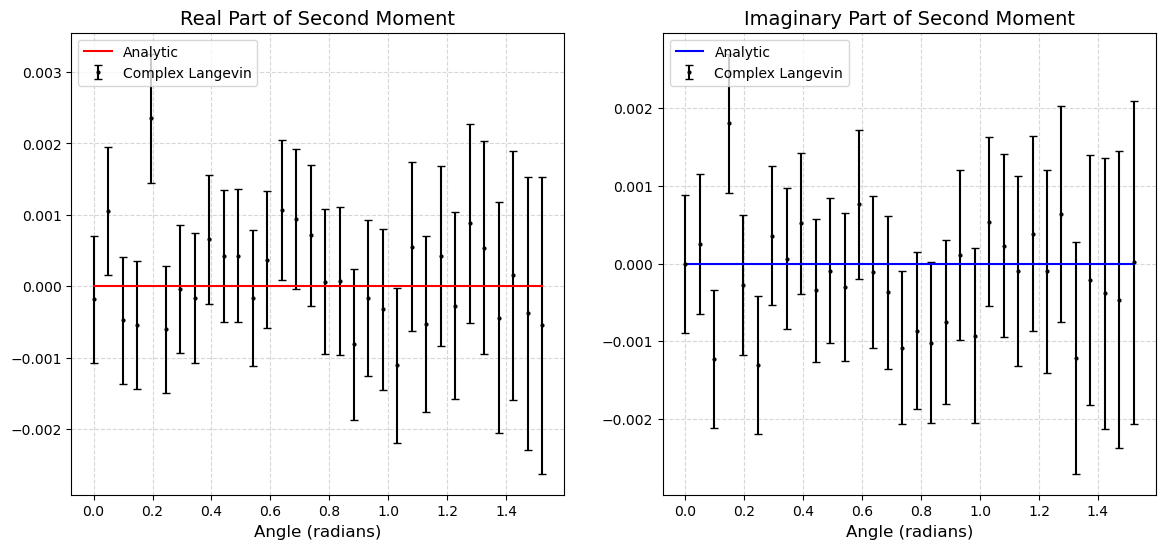

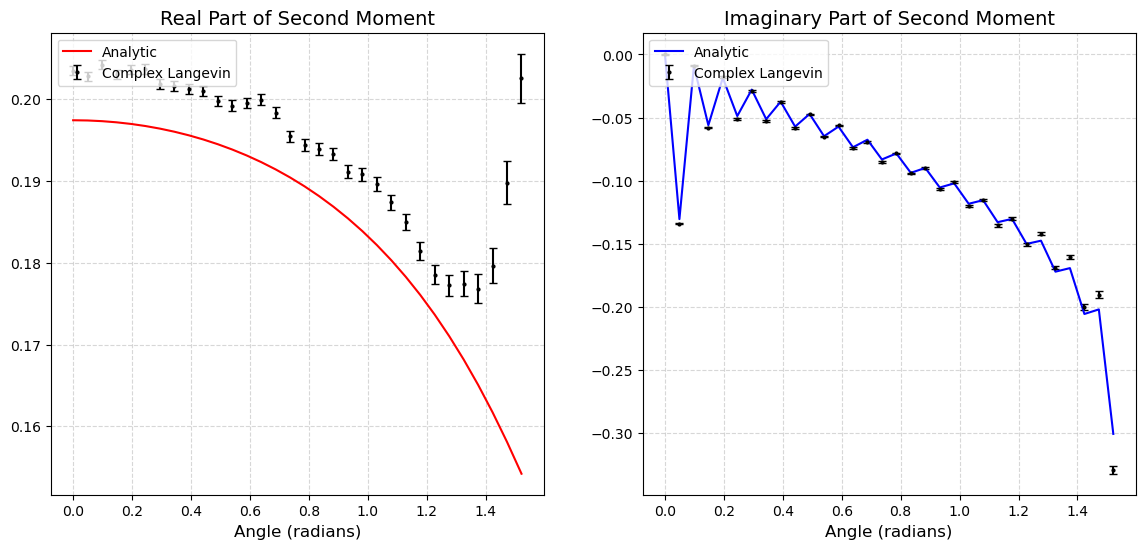

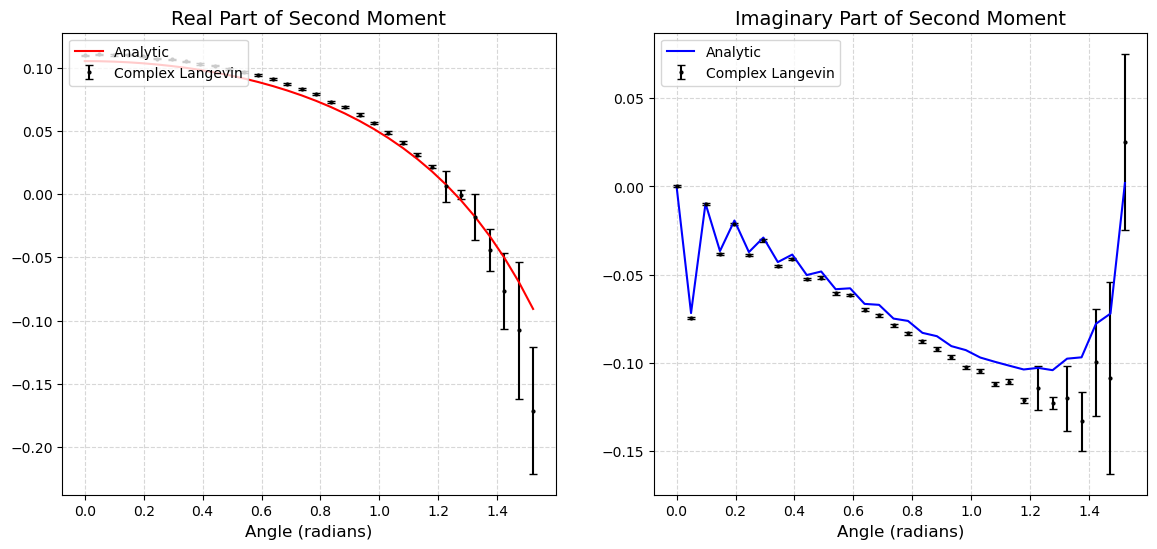

In [ ]:
import scienceplots
from elli.kkr.kkr import *



# plt.style.use('science')
for name, tr in sim.trackers.items():

    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

    cl_estimate = np.array(cl_estimate_dict[name])
    errors = np.array(errors_dict[name])
    angles = np.array(angles_dict[name])

    kramers_imag = re2im(cl_estimate.real, angles)
    axes[0].errorbar(angles, cl_estimate.real, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)
    axes[1].errorbar(angles, kramers_imag.real, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)


    axes[0].plot(angles_ana, exact_dict[f"{name}_phi4"].real, color='red', label = "Analytic")
    kramers_imag = re2im(exact_dict[f"{name}_phi4"].real, angles_ana)
    # axes[1].plot(angles_ana, exact_dict[f"{name}_phi4"].imag, color='red', label = "Analytic")
    axes[1].plot(angles_ana, kramers_imag, color='blue', label = "Analytic")

    # Titles
    axes[0].set_title('Real Part of Second Moment', fontsize=14)
    axes[1].set_title('Imaginary Part of Second Moment', fontsize=14)

    # Formatting
    for ax in axes:
        ax.set_xlabel('Angle (radians)', fontsize=12)
        ax.grid(alpha=0.5, linestyle='--')
        ax.legend(fontsize=10, loc = 'upper left')
        ax.tick_params(axis='both', which='major', labelsize=10)

    # axes[0].set_ylabel(r'Re $\langle x^2 \rangle$', fontsize=12)
    # axes[1].set_ylabel(r'Im $\langle x^2 \rangle$', fontsize=12)

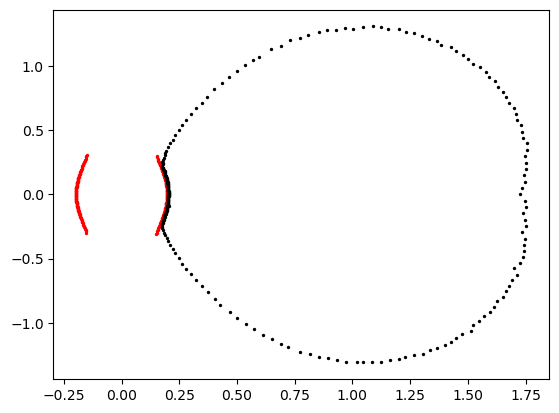

In [ ]:
plt.scatter(exact_dict[f"2_moment_phi4"].real, exact_dict[f"2_moment_phi4"].imag, color = 'red', s=2)
plt.scatter(cl_estimate.real, cl_estimate.imag, color = 'black', s=2)

In [ ]:
from elli.kkr.kkr import *



In [ ]:
im2re(np.array([1,2,3,4,5]), np.array([1,2,3,4,5]))

array([ 0.        ,  3.38317936,  1.89167018,  1.81487161, -2.50605879])